# Models without any fault
This example tries to visualize how simply _GeoMeshPy_ can export results from _Gempy_. <br><br>
This notebook include a simple model with five layers and no fault. <br><br>
To see how _Gempy_ works, please see https://github.com/cgre-aachen/gempy

In [2]:
# This block of code initializes the first model in Gempy
import gempy as gp
import numpy as np
geo_model = gp.create_model('4_layers')
gp.init_data(geo_model, [0., 100., 0., 50., 0., 100.], [50, 25, 50],
            path_i = 'no_f_interfaces_4.csv',
            path_o = 'no_f_orientations_4.csv');
gp.map_series_to_surfaces(geo_model,
                         {"Strati_series":('unit_1', 'unit_2', 'unit_3', 'unit_4')})
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])
sol = gp.compute_model(geo_model)

# this block is exporting required parameters from Gmpy to be used in GeoMeshPy
extent = geo_model.grid.regular_grid.extent
resolution = geo_model.grid.regular_grid.resolution.reshape(-1,1)
df=geo_model.series.df
if len (np.unique (sol.fault_block))>1:
    no_of_faults=df.groupby(by='BottomRelation').count().iloc[1,0]
else:
    no_of_faults=0
surfaces=geo_model.surface_points.df['surface']
if no_of_faults==0:
    surfaces_layer=[i for i in surfaces.unique()]
else:
    surfaces_layer=[i for i in surfaces.unique()[no_of_faults:]]
    fault_name=[i for i in surfaces.unique()[:no_of_faults]]
surfaces_layer.append('Basement')
grid=geo_model.grid.values
z_resolution = abs (grid[0,-1] - grid[1,-1])
# visualizazion
gp.plot_3d(geo_model, plotter_type='background')

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                      values
range                 150.0
$C_o$            535.714286
drift equations      [3, 3]


C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\pyvista\plotting\plotting.py:1318: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


In 3D your result should look like this: <br>
The model contains five formations with a quite challenging gemetry <br> <br>

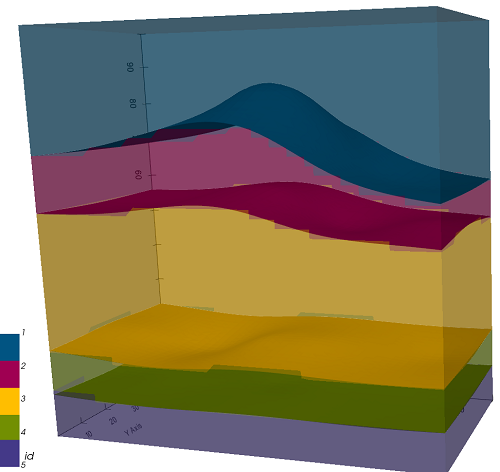

Next cell makes the model probabilistic. Infact, the depths of one the layers (_unit_1_) are <br>
are considered to be uncertain. Again, please refer to _GemPy_ documentations for more details ().

In [4]:
import copy
import math
import random
from numpy import savetxt
ver=[]
fault_ind=[]
repre_pts=[]
n_iter = 10
for i in range(n_iter):
#     Initialization of the Gempy model
    df_int_X      = copy.copy(geo_model.surface_points.df['X'])
    df_int_Y      = copy.copy(geo_model.surface_points.df['Y'])
    df_int_Z      = copy.copy(geo_model.surface_points.df['Z'])
    df_or_X       = copy.copy(geo_model.orientations.df['X'])
    df_or_Y       = copy.copy(geo_model.orientations.df['Y'])
    df_or_Z       = copy.copy(geo_model.orientations.df['Z'])
    df_or_dip     = copy.copy(geo_model.orientations.df['dip'])
    df_or_azimuth = copy.copy(geo_model.orientations.df['azimuth'])
    surfindexes = list(geo_model.surface_points.df.index)
    orindexes = list(geo_model.orientations.df.index)
    geo_model.modify_surface_points(surfindexes, X=df_int_X, Y=df_int_Y, Z=df_int_Z)
    geo_model.modify_orientations(orindexes, X=df_or_X, Y=df_or_Y, Z=df_or_Z,dip = df_or_dip, azimuth = df_or_azimuth)
#     Layers surface point and orientations
    layer_surfpoints = geo_model.surface_points.df.surface.isin(['unit_1'])
    indexes_La_sp = geo_model.surface_points.df[layer_surfpoints].index
    layer_orient = geo_model.orientations.df.surface.isin(['unit_1'])
    index_La_o = geo_model.orientations.df[layer_orient].index
#     Randomization_Method
    std1=1
    rand1 = np.random.uniform(-std1, std1, size=1)
#     Randomized_input
    new_Z_La = geo_model.surface_points.df['Z'].values[layer_surfpoints] + rand1
    #     Modifier
    geo_model.modify_surface_points(indexes_La_sp, Z=new_Z_La)

#     this block updates the model
    geo_model.update_to_interpolator()
    sol=gp.compute_model(geo_model)
    
    # Export Block
    ver.append(geo_model.solutions.vertices)
    geo_model.solutions.lith_block = np.round(geo_model.solutions.lith_block)
    fault_ind.append (sol.fault_block.T[0:sol.grid.values.shape[0]]) # of course if you hav eno fault, it will be 
    # an empty list

Next cell reshpes exported data from _Gempy_ and also exports them as _.csv_ files to be <br>
useable for next times, without runing the previous cells. If you do not have Gempy installed, <br> you can use the exported csv files in the output folder of this example.

In [3]:
lays_fault_name=geo_model.surface_points.df.loc[:, 'surface'].unique()
all_vers=[list(column) for column in zip(*ver)]
no_layers = len(all_vers)
df=geo_model.series.df
if len (np.unique (sol.fault_block))>1:
    no_of_faults=df.groupby(by='BottomRelation').count().iloc[1,0]
else:
    no_of_faults=0
len_rough = np.array([[len(x) for x in all_vers[y]] for y in range(len(all_vers))])
savetxt('len_rough.csv', len_rough, delimiter=',')
rough_vers = [l.tolist() for l in [np.concatenate(d) for d in all_vers]]
for ind, vertices in enumerate(rough_vers):
    savetxt(f'rough_vertices_{ind}.csv', np.array(vertices), delimiter=',')
savetxt('extent.csv', extent, delimiter=',')
savetxt('z_resolution.csv', np.array([z_resolution]), delimiter=',')

This cell imports exported data from _Gempy_ and some features of the model can also be introduced by the user.

In [5]:
import numpy as np
import glob
from numpy import genfromtxt
import copy
import math
import random
from numpy import savetxt
extent = genfromtxt('extent.csv', delimiter=',') # comes from Gempy export cell
z_resolution = genfromtxt('z_resolution.csv', delimiter=',') # comes from Gempy export cell or can be easily defines
# by the user. this value is an important one because it should be based on the expected mesh size around your surface
len_rough = genfromtxt('len_rough.csv', delimiter=',') # comes from Gempy export cell
all_roughs = []
files_ve = glob.glob("rough_vertices_*.csv")
files_ver = sorted(files_ve, key=lambda name: int(name[15:-4]))
for name_ver in files_ver:
    data = genfromtxt(name_ver, delimiter=',')
    all_roughs.append(data)
all_roughs = [[i] for i in all_roughs]
all_vers = []
for vert, length in zip (all_roughs, len_rough):
    [a] = vert
    new_arrs = np.split(a, np.cumsum(length).astype('int').tolist())[:-1]
    all_vers.append(new_arrs)
no_of_faults = 0 # can be also exported from Gempy export cell
n_iter = 10 # can be also exported from Gempy export cell
name_of_layers = np.array(['unit_1', 'unit_2', 'unit_3', 'unit_4', 'basement']) # can be also exported from Gempy export cell
resolution = np.array([[50], [25], [50]]) # can be also exported from Gempy export cell

After installing _GeoMeshPy_ using the _geomeshconv_ package eixting in _Pypi_, aou can use <br>
the module. For installation you can simpy try _pip install geomeshconv_. You can find it in this link https://pypi.org/project/geomeshconv/

In [6]:
from GeoMeshPy import vmod # the class vmod allows you for doing all the required calculations

## Inputs of the class
Next cell allows the _vertice_modifier_ of _GeoMeshPy.mode_ for converting raw _Gempy_ output <br>
into readable point for GMSH. Details of needed inputs for the class are addressed in the following:<br><br>
1. n_iterations : defines how many geological realizations are going to be used
2. no_of_faults : how many faults does exist in the model, if no fault is there keep it as 0
3. all_vers : a list arrays representing all the features, i.e. faults or layers of the model. In case of having <br> faults, mentione them first and after them put formaions
4. formations : an array of formations' names including the last formation (usually called basement in GemPy terminology)
5. mesh_resolution : for this factor it is needed to have a prediction on the mesh size in the adjacency of layers.
6. fault_relation : it defines whether there is a passive fault in the model or not. Refer to Examples to see it<br>
in more details. Also see https://www.gempy.org/tutorials for more details.
7. extent : defines the extent of the model in x, y and z direction.
8. resolution : resolution of the model in all direction. If the extent in X direction goes from 0 to 100 m, <br>
a 20 resolution in x direction says that in every five meter there should be a vertice.

In [7]:
fr = np.array([[]])
mesh_rosultion = 5
n_iterations = 10
no_of_faults = 0
model = vmod.vertice_modifier(10, 0, all_vers, name_of_layers, mesh_rosultion, fr, extent, resolution)
new_result_list = model.contact_generator()[0]
length_layers = model.contact_generator()[1]
repre_pts = model.contact_generator()[2]

## Outputs of the class
In case of having no Fault in the model (like the example of this notebook), only three <br> 
parameters are important for us to be fed into _GMSH_:
<br>
1. Points respresenting the layers' contacts (called as _new_result_list_ in previous cell)
2. Length of each layers' contacts (called as _length_layers_ in previous cell). 3D visualization can help <br>
to see what we mean by this length.
3. Some parts of the model that we are sure for example Formation A is there. this list is called <br>
_repre_pts_ as an abbreviation for representative points. One of the advantages of _Geo_Mesh_Py_ is this list. <br>
Because by pertubing the model position of formations changes but _Geo_Mesh_Py_ can help to attribute <br>
Formations to their positions. This list can help us in _GMSH_ to call each volume of the model by its <br>
geological name which can be used later as hysical properties in numerical solvers.

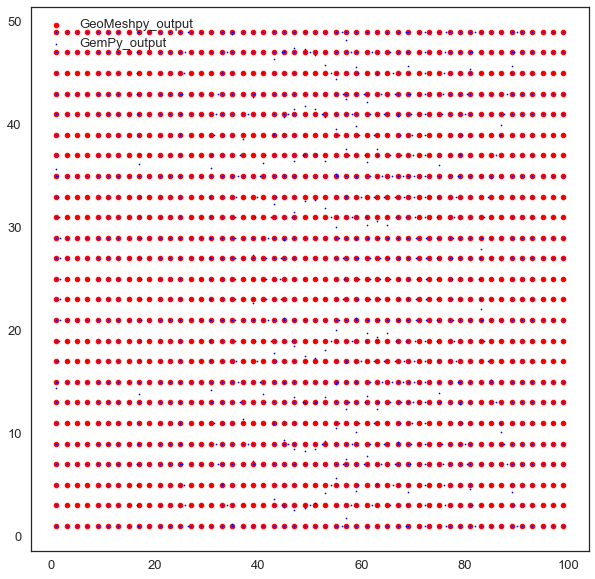

In [30]:
# 2D visualization Cell --> This plot visualizes the redundant irregular vertices cretaed in Gempy
import matplotlib.pyplot as plt
%matplotlib inline

Gempy_out_1 = all_vers[0][0] # Vertices of Gempy for first contact in first iteration

First_iter_cl = np.array(new_result_list[0]) # vertices exported from GeoMeshPy in the first iteration
length = np.array(length_layers[0]).astype('int')# it recals the lengths of conatcts of the layers
le = np.cumsum (length) # accumulative sime of lengths

x = First_iter_cl[:le[0],0]
y = First_iter_cl[:le[0],1]

fig, axs = plt.subplots(1, 1, figsize=(10.,10.))
axs.scatter(x, y, c = 'r', s = 20, label='GeoMeshpy_output', facecolor='None', linewidths=1.1)
axs.scatter(Gempy_out_1[:,0], Gempy_out_1[:,1], c = 'b', s = 1.5, label='GemPy_output')
axs.legend()
plt.show()

regarding the plot, some extra blue dots are clearly observable but<br>
_GeoMeshPy_ removes them to make the grid regular. <br>
In the folloing fig you see a higher resolution of previous fig <br><br>

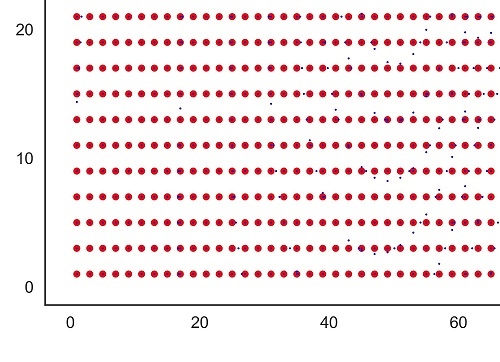

In [31]:
# 3D visualization Cell --> This plot visualizes the redundant irregular vertices created in Gempy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
%matplotlib qt5

length = np.array(length_layers[0]).astype('int')# it recals the lengths of conatcts of the layers
le = np.cumsum (length) # accumulative sime of lengths

x = First_iter_cl[:,0]; y = First_iter_cl[:,1]; z = First_iter_cl[:,2]

x_contact_1=x[:le[0]]; y_contact_1=y[:le[0]]; z_contact_1=z[:le[0]]
x_contact_2=x[le[0]:le[1]]; y_contact_2=y[le[0]:le[1]]; z_contact_2=z[le[0]:le[1]]
x_contact_3=x[le[1]:le[2]]; y_contact_3=y[le[1]:le[2]]; z_contact_3=z[le[1]:le[2]]
x_contact_4=x[le[2]:le[3]]; y_contact_4=y[le[2]:le[3]]; z_contact_4=z[le[2]:le[3]]

Gempy_out_2 = all_vers[1][0] # Vertices of Gempy for second contact in first iteration
Gempy_out_3 = all_vers[2][0] # Vertices of Gempy for third contact in first iteration
Gempy_out_4 = all_vers[3][0] # Vertices of Gempy for fourth contact in first iteration

reps = np.array(repre_pts[0])[:,:-1].astype('float') # these point are where we are sure about the formation


fig = plt.figure()
ax = fig.add_subplot (111, projection="3d")

ax.scatter3D(x_contact_1, y_contact_1, z_contact_1, color='b', s=15, label='First contact', facecolor='None', linewidths=1)
ax.scatter3D(x_contact_2, y_contact_2, z_contact_2, color='m', s=15, label='Second contact', facecolor='None', linewidths=1)
ax.scatter3D(x_contact_3, y_contact_3, z_contact_3, color='r', s=15, label='Third contact', facecolor='None', linewidths=1)
ax.scatter3D(x_contact_4, y_contact_4, z_contact_4, color='g', s=15, label='Fourth contact', facecolor='None', linewidths=1)

ax.scatter3D(Gempy_out_1[:,0], Gempy_out_1[:,1], Gempy_out_1[:,2], color='k', s=1, label='Gempy output')
ax.scatter3D(Gempy_out_2[:,0], Gempy_out_2[:,1], Gempy_out_2[:,2], color='k', s=1)
ax.scatter3D(Gempy_out_3[:,0], Gempy_out_3[:,1], Gempy_out_3[:,2], color='k', s=1)
ax.scatter3D(Gempy_out_4[:,0], Gempy_out_4[:,1], Gempy_out_4[:,2], color='k', s=1)

ax.scatter3D(reps[:,0], reps[:,1], reps[:,2], color='r', s=50, marker = '*', label='representative points')

plt.legend()
ax.grid(None)
plt.show()

If you run the model successfully, the following fig will be resulted: <br>
In the fig please notice the _representative-points_ visualized as red stars. <br>
These point will help _GMSH_ to map its volumes to geological formations.  <br> <br>
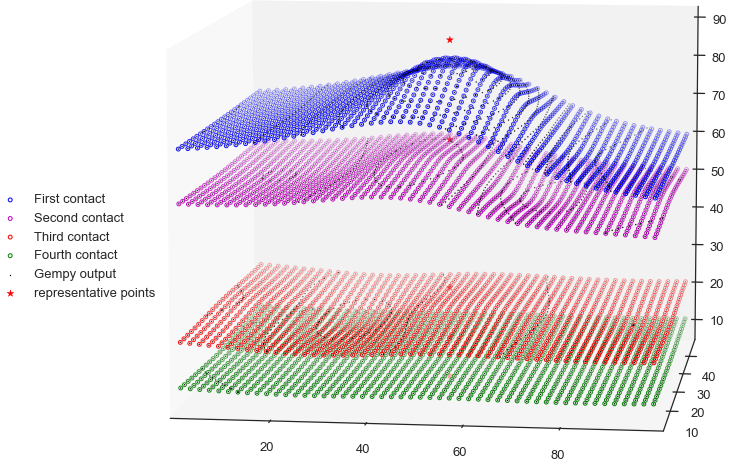

In [9]:
# coordinates of the existing fault in the model
wells = [[50.,25.,50.],[50.,25.,40.], [55.,25.,35.]]
wel_iter=np.split (np.tile(wells, (n_iter, 1)), n_iter)
wells_cord=[i.tolist() for i in wel_iter]
well_points=[[3.]]
well_p_iter=np.split (np.tile(well_points, (n_iter, 1)), n_iter)
well_points=[i.tolist() for i in well_p_iter]
wl_names=['W_1']

## Outputs of the _GMSH_
Next cell makes 10 different meshes based on the created geological model. <br>
For sure _GMSH_ installation is required. Please have a look at https://gmsh.info/doc/texinfo/gmsh.html <br>
and https://gitlab.onelab.info/gmsh/gmsh/-/tree/master/tutorials/python to get yourself <br>
familiarized with _GMSH_.<br>
The following cell is quited intense because it is doing quite lots of things:<br>
1. Creating a box with the same site as geological model
2. Importing all the vertices of the layers as points
3. Splitting vertices based on the length of each layers (as shown in 3D visialization cell).
4. Passing a surface through each layers or patches (refer to in faulted examples)
5. Importing wells
6. Cutting the created box based on the generated surfaces and embedding all surfaces, lines and points
to their related higher dimentional entities.
7. Mapping each created volume to its related formation. Representative point are doing this correlation.
At some point of the model we can find out with formation exist there and then we can call that
volume with name of that point, i.e. the formations name.
8. A myriad of refinement approaches are available in gmsh and some are also applied in the nextcell to refine mesh
close to well and contact of layers.
9. As much as iterations, mesh files will be generated at the end.

In [10]:
import gmsh
import itertools
from collections import defaultdict
from itertools import chain
gmsh.initialize()
if no_of_faults == 0: # LIFE IS EASIER WITHOUT ANY FAULT :-)
    def cleanup_and_mesh(entities_to_preserve):
        # remove all embedded constraints, i.e. the entities that are not on the
        # boundary of others
        entities = gmsh.model.getEntities()
        for e in entities:
            emb = gmsh.model.mesh.getEmbedded(e[0], e[1])
            gmsh.model.mesh.removeEmbedded([e])
            for p in entities_to_preserve:
                if p in emb:
                    gmsh.model.mesh.embed(p[0], [p[1]], e[0], e[1])
        # remove all surfaces, curves and points that are not connected to any
        # higher-dimensional entities
        gmsh.model.removeEntities(gmsh.model.getEntities(2), True)
        cc = gmsh.model.getEntities(1)
        for c in curves_to_preserve:
            cc.remove(c)
        gmsh.model.removeEntities(cc, True)
        gmsh.model.removeEntities(gmsh.model.getEntities(0))
        
        # get all surfaces that are not of type "Plane", i.e. all surfaces except the
        # box
        surfaces = [s[1] for s in gmsh.model.getEntities(2) if gmsh.model.getType(s[0], s[1])
                    != 'Plane']
        layers_contacts = np.array(surfaces).reshape(-1,1).tolist()
        surface_after = gmsh.model.getEntities(2)
        points = copy.deepcopy(surface_new_tag)
        check_values = [row[-1] for row in surface_after]
        extracted = []
        for sublist in points:
            second_vals = [sec for fir, sec in sublist]
            if all(val in check_values for val in second_vals):
                extracted.append(second_vals)
        
        surrounding_box = [x for x in extracted if x not in layers_contacts]

        # create a distance + threshold mesh size field
        gmsh.model.mesh.field.add("Distance", 1) # refiement close to the well
        gmsh.model.mesh.field.setNumbers(1, "CurvesList", np.array(curves_to_preserve)[:,1].tolist())
        gmsh.model.mesh.field.setNumber(1, "Sampling", 100)
        gmsh.model.mesh.field.add("Threshold", 2)
        gmsh.model.mesh.field.setNumber(2, "InField", 1)
        gmsh.model.mesh.field.setNumber(2, "SizeMin", 2)
        gmsh.model.mesh.field.setNumber(2, "SizeMax", 20)
        gmsh.model.mesh.field.setNumber(2, "DistMin", 6)
        gmsh.model.mesh.field.setNumber(2, "DistMax", 30)
        
        gmsh.model.mesh.field.add("Distance", 3) # refiement close to contacts of layers
        gmsh.model.mesh.field.setNumbers(3, "SurfacesList", surfaces)
        gmsh.model.mesh.field.setNumber(3, "Sampling", 100)
        gmsh.model.mesh.field.add("Threshold", 4)
        gmsh.model.mesh.field.setNumber(4, "InField", 3)
        gmsh.model.mesh.field.setNumber(4, "SizeMin", 3)
        gmsh.model.mesh.field.setNumber(4, "SizeMax", 20)
        gmsh.model.mesh.field.setNumber(4, "DistMin", 10)
        gmsh.model.mesh.field.setNumber(4, "DistMax", 30)

        gmsh.model.mesh.field.add("Min", 5)
        gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2, 4])
        gmsh.model.mesh.field.setAsBackgroundMesh(5)
        gmsh.option.setNumber("Mesh.MeshSizeMax", 30)
        # don't extend mesh sizes from boundaries and use new 3D algo
        gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
        gmsh.option.setNumber("Mesh.Algorithm3D", 10)
        gmsh.model.mesh.generate(3)        
        # using representative points to create physical volumes
        rep = [list(x) for _,x in itertools.groupby(rep_pnt,lambda x:x[3])]
        vol_num = np.arange(1, 1+len(rep))
        for ind, surfaces in enumerate (rep):
            tags = []
            for sects in surfaces:
                eleTag = gmsh.model.mesh.getElementByCoordinates(float (sects[0]), float (sects[1]), float (sects[2]))[0]
                eleType, eleNodes, entDim, entTag = gmsh.model.mesh.getElement(eleTag)
                tags.append(entTag)
            gmsh.model.addPhysicalGroup(3, tags, vol_num[ind])
            gmsh.model.setPhysicalName(3, vol_num[ind], sects[-1])  
            
        # adding wells as physical lines
        for lines, well_name in zip (sp_well, wl_names):
            l1 = gmsh.model.addPhysicalGroup(1, lines.tolist())
            gmsh.model.setPhysicalName(1, l1, well_name)
            
        # adding surrounding surfaces as physical surfaces to be useable as boundary conditions
        around_box = ['in', 'out', 'front', 'back', 'bottom', 'top']       
        for tag_nu, name in zip (surrounding_box, around_box):
            ps1 = gmsh.model.addPhysicalGroup(2, tag_nu)
            gmsh.model.setPhysicalName(2, ps1, name)
        gmsh.write("Four_layers_" + str(kk) + ".msh")
        gmsh.fltk.run()
    gmsh.initialize()
    degree = 3
    numPointsOnCurves = 10
    numIter = 10
    anisotropic = False
    tol2d = 0.00001
    tol3d = .1
    tolAng = 1
    tolCurv = 1
    maxDegree = 3
    maxSegments = 100
    sets = zip(new_result_list, repre_pts, wells_cord, well_points)
    for kk, (vertices, rep_pnt, well_cord, well_p) in enumerate(sets):
        ar = np.array(vertices)
        l_tags = []
        gmsh.model.occ.addBox(min(ar[:,0]),min(ar[:,1]),extent[-2],
                              max(ar[:,0])-min(ar[:,0]),max(ar[:,1])-min(ar[:,1]),extent[-1])
        spl_num = np.cumsum(length_layers[kk]).tolist()[:-1] # each layer is separated
        spl_num = [int (i) for i in spl_num]
        sep_ar = np.split(ar,spl_num)
        for ind, point_clouds in enumerate (sep_ar):
            point_clouds=point_clouds[np.lexsort((point_clouds[:,1],point_clouds[:,0]))]
            i_l = point_clouds.tolist()
            for [x, y, z] in i_l:
                gmsh.model.occ.addPoint(x, y, z)
            corn_layers= point_clouds [(point_clouds[:,0] == np.min(point_clouds[:,0])) | 
                           (point_clouds[:,0] == np.max(point_clouds[:,0])) |
                           (point_clouds[:,1] == np.min(point_clouds[:,1])) |
                           (point_clouds[:,1] == np.max(point_clouds[:,1]))]
            corn_layers = corn_layers[np.lexsort((corn_layers[:,1],corn_layers[:,0]))]
            h = corn_layers   
            pnt = h[:,0:-1].tolist()
            arround_pts = model.rotational_sort(pnt, (np.mean(np.array(pnt)[:,0]),np.mean(np.array(pnt)[:,1])),True)
            arround_pts = np.array(arround_pts)
            tags = np.where((point_clouds[:,:-1] == np.array(arround_pts)[:,None]).all(-1))[1]+1
            l_tags.append(len(tags))
            start_point = int (8+np.sum(length_layers[kk][0:ind]))
            start_line = int (13+np.sum(l_tags[0:ind]))
            for i in range (len(tags)): # this for loop creates the exterior lines of each cloud
                if i!=len(tags)-1:
                    gmsh.model.occ.addSpline([tags[i] + start_point,tags[i+1] + start_point])
                else:
                    gmsh.model.occ.addSpline([tags[i] + start_point,tags[0] + start_point])
            gmsh.model.occ.addCurveLoop([i for i in range (start_line, start_line + len(tags))], start_line)
            gmsh.model.occ.addSurfaceFilling(start_line, start_line,
                                             [m for m in range (start_point+1, start_point+np.max(tags))
                                              if m not in tags + start_point],
                                             degree,
                                             numPointsOnCurves,
                                             numIter,
                                             anisotropic,
                                             tol2d,
                                             tol3d,
                                             tolAng,
                                             tolCurv,
                                             maxDegree,
                                             maxSegments) # create surface by connecting exterior lines
                                                                             # and inclding interior ones
        
        gmsh.model.occ.synchronize()

        in_surf = gmsh.model.occ.getEntities(2)

        # Importing Wells:

        tag_well = np.arange(10000, 10000+len(np.array(well_cord)))
        well_p = np.array(well_p[0]).astype('int')
        tag_well_po = np.split (tag_well, np.cumsum(well_p)[:-1])
        well_po = np.split (np.array(well_cord), np.cumsum(well_p)[:-1])  
        for cord, tag_nu in zip (well_po, tag_well_po):
            for [x, y, z], num in zip (cord,tag_nu):
                gmsh.model.occ.addPoint(x, y, z, tag=num)
        well_l = well_p-1        
        tag_w_l = np.arange(5000, 5000+np.sum(well_l))
        wl = [i.tolist() for i in tag_w_l]
        tag_well_l = np.split (tag_w_l, np.cumsum(well_l)[:-1])

        for po, tag_num in zip (tag_well_po, tag_well_l):
            for i in range (len(po)-1):
                gmsh.model.occ.addLine (po[i], po[int(i+1)], tag = tag_num[i])
        in_wells = [(1, i) for i in tag_w_l]
        out_all = gmsh.model.occ.fragment(in_surf+in_wells, gmsh.model.occ.getEntities(3))#[1]
        out = out_all[1]
        surface_new_tag = out[0:len(in_surf)]
        c = out[len(in_surf):len(in_surf+in_wells)]
        curves_to_preserve = [item for sublist in c for item in sublist]           
        gmsh.model.occ.synchronize()
        points_to_preserve = gmsh.model.getBoundary(curves_to_preserve, combined=False)
        line_sp = np.array([])
        for i in range (len(points_to_preserve)-1):
            if i%2 != 0:
                if points_to_preserve[i][1] != points_to_preserve[i+1][1]:
                    brk=int ((i+1)/2)
                    line_sp=np.append(line_sp, brk)
        sp_well = np.split(np.array(curves_to_preserve)[:,1],line_sp.astype('int'))
        cleanup_and_mesh(curves_to_preserve + points_to_preserve)
        gmsh.clear()
    gmsh.finalize()

After making the mesh, you will see meshes similar to the following figures:<br> <br> <br>

|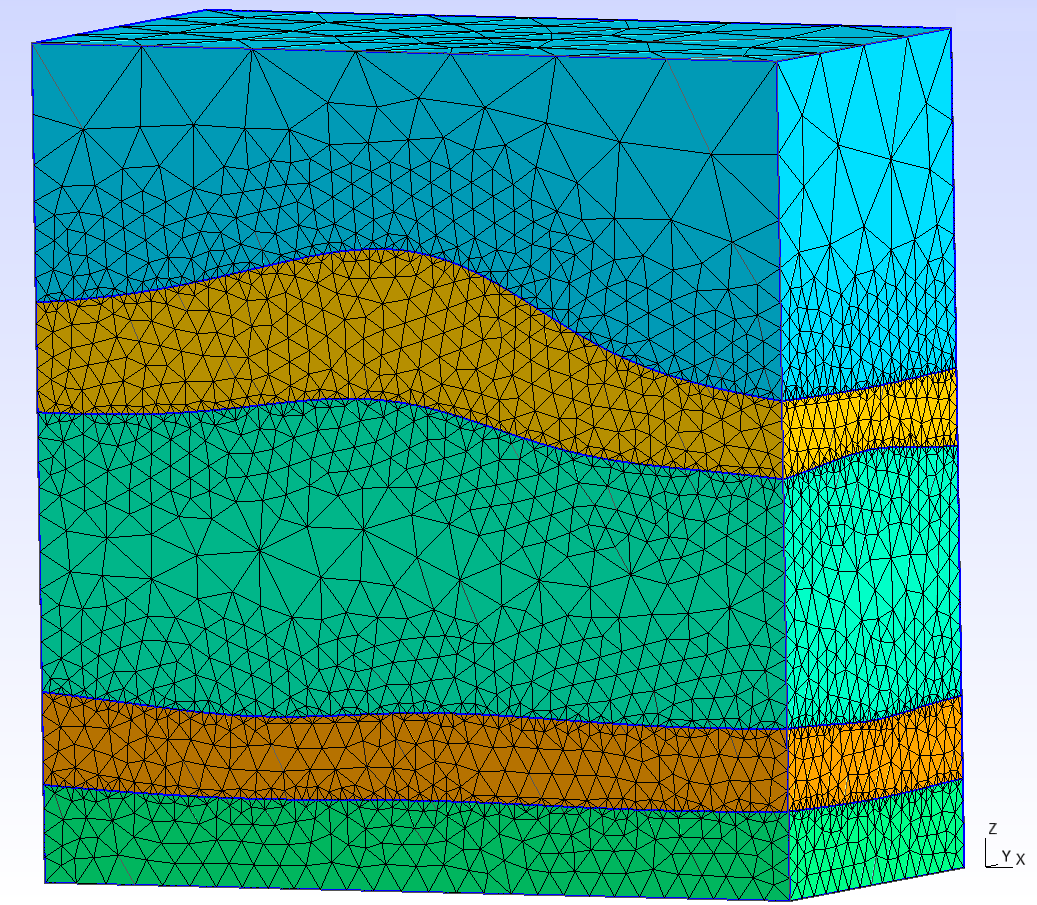 |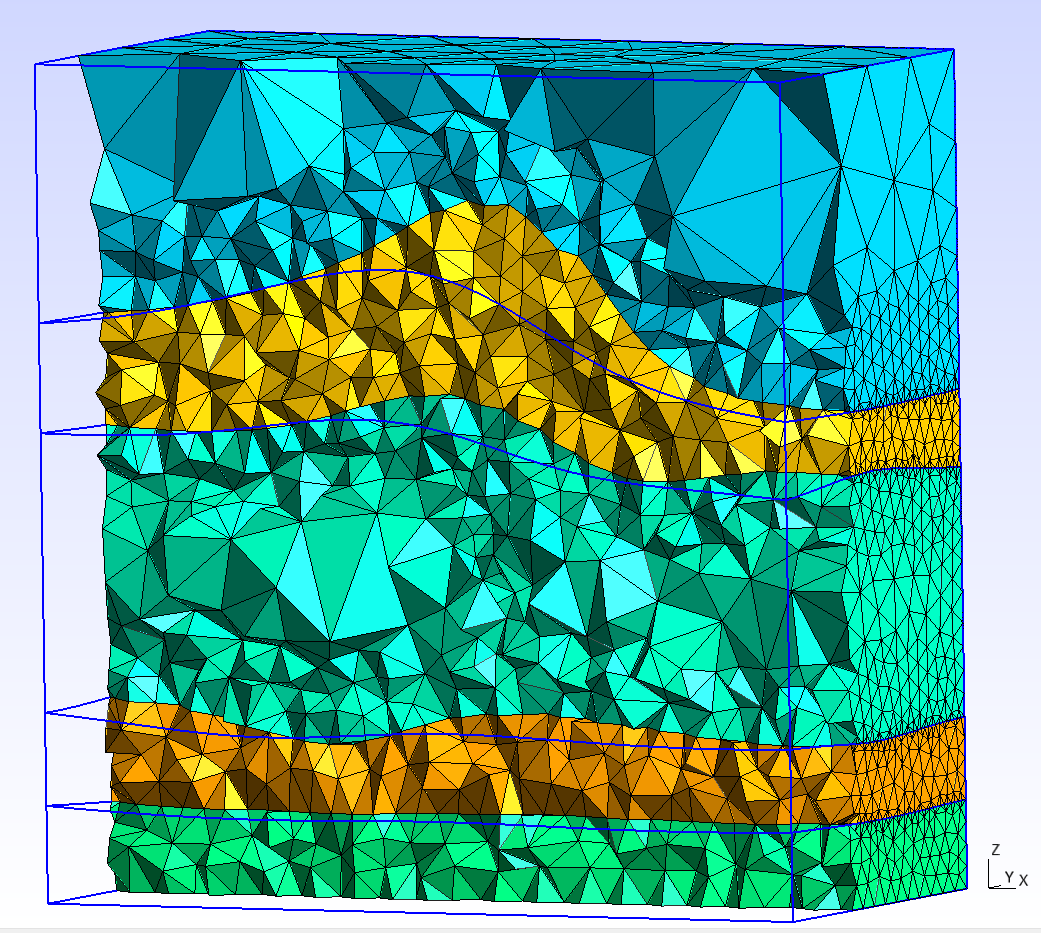|
|-|-|
|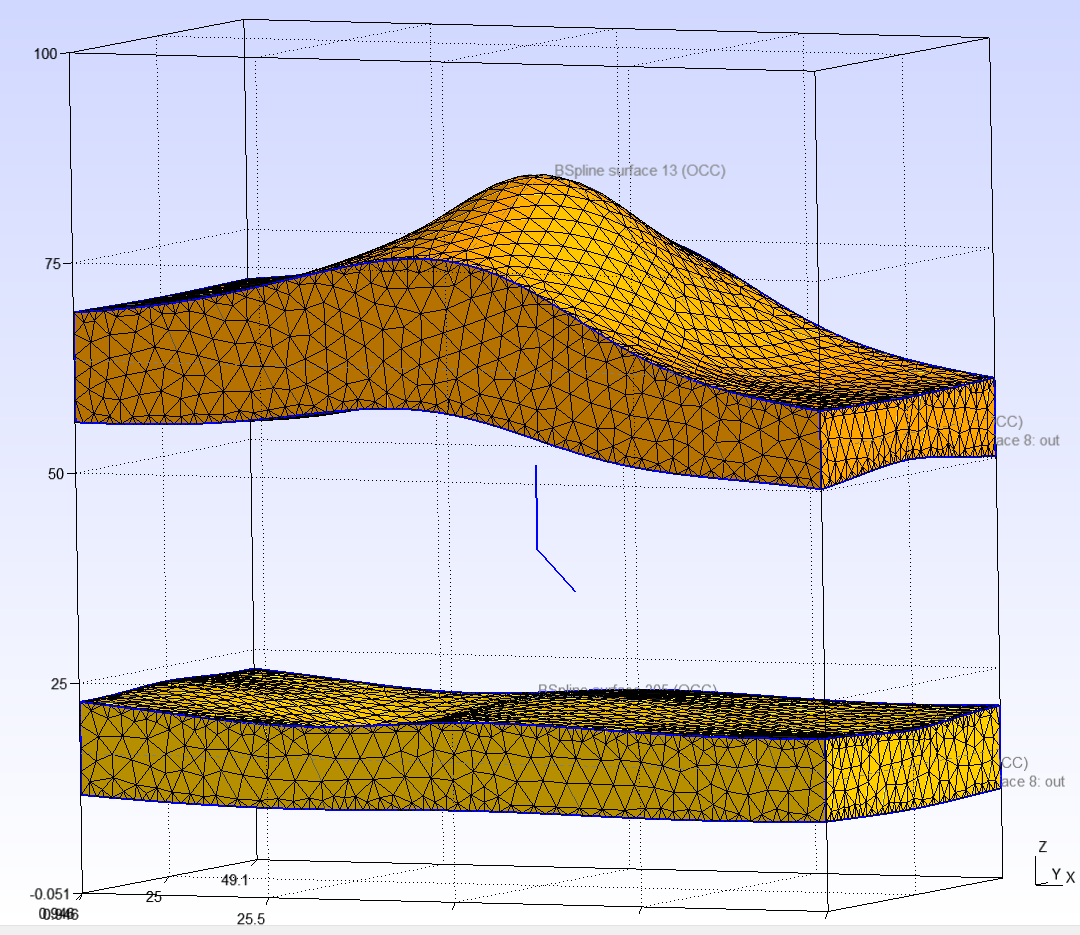 | 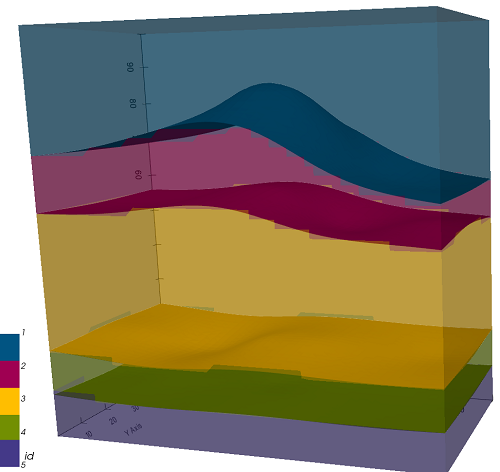|
